In [19]:
import numpy as np
import pandas as pd
import xarray as xr
import math
from scipy import interpolate



ds_u = xr.open_dataset('uwnd.mon.mean.nc')

# =========  uwnd.mon.mean.nc ======
#
# This data has the following XARRAY dimensions
# -------
# - lat     (Latitude)  --> 73          [Type= float]   90.0,  87.5,  85.0,  82.5  ..... -87.5,  -90.0
# - level   (Level)     --> 17          [Type= float]   1000.0,  925.0,  850.0     ..... 30.0,  20.0,  10.0
# - lon     (Longitude) --> 144         [Type= float]   0.0,  2.5,  5.0            ..... 355.0  357.5
# - time    (Time)      --> 844         [Type=datetime] 1948-01-01,  1948-02-01    ..... 2018-04-01

ds_v = xr.open_dataset('vwnd.mon.mean.nc')
ds_temp = xr.open_dataset('air.mon.mean.nc')

# PRESSURE ALTITUDE
# NOAA formula from converting millibars (mb) to pressure altitude in feet (ft)
#
#     FT = 145366.45 * ( 1 - ( ( Station pressure in mb / 1013.25 )^0.190284  ) ) 
#

# DATA SET/ARRAY FORMAT
#
# LEVEL  [ 0 to 16 ]  - 1000.0 millibar

#iterate through a time period (YEARLY!!!!)
#  -------------------------------------------------------------------------------------
# [768] -> 2012-01-01       [769] -> 2012-02-01     [770] -> 2012-03 ...    [779] -> 2012-12
# [780] -> 2013-01-01       [781] -> 2013-02-01     [782] -> 2013-03 ...    [827] -> 2013-12
# ...                       ...                     ...              ...    ...
# [828] -> 2017-01-01       [829] -> 2017-02-01     [830] -> 2017-03        [839] -> 2017-12
# [840] -> 2018-01          [841] -> 2018-02

# so roughly 5 years
# Start from 2017 backwards to include full-year monthly data (2018 only partial)

start = 828
NUM_YRS = 10

################# RESULT ###############
RESULT_month_wdir_10000ft = np.array([])
RESULT_month_wspd_10000ft = np.array([])

MONTH_IX = {}
MONTH_IX[0] = []
MONTH_IX[1] = []
MONTH_IX[2] = []
MONTH_IX[3] = []
MONTH_IX[4] = []
MONTH_IX[5] = []
MONTH_IX[6] = []
MONTH_IX[7] = []
MONTH_IX[8] = []
MONTH_IX[9] = []
MONTH_IX[10] = []
MONTH_IX[11] = []
for for_year in range(0,NUM_YRS):
    MONTH_IX[0] = MONTH_IX[0] + [ (start+0) - (12*for_year) ]
    MONTH_IX[1] = MONTH_IX[1] + [ (start+1) - (12*for_year) ]
    MONTH_IX[2] = MONTH_IX[2] + [ (start+2) - (12*for_year) ]
    MONTH_IX[3] = MONTH_IX[3] + [ (start+3) - (12*for_year) ]
    MONTH_IX[4] = MONTH_IX[4] + [ (start+4) - (12*for_year) ]
    MONTH_IX[5] = MONTH_IX[5] + [ (start+5) - (12*for_year) ]
    MONTH_IX[6] = MONTH_IX[6] + [ (start+6) - (12*for_year) ]
    MONTH_IX[7] = MONTH_IX[7] + [ (start+7) - (12*for_year) ]
    MONTH_IX[8] = MONTH_IX[8] + [ (start+8) - (12*for_year) ]
    MONTH_IX[9] = MONTH_IX[9] + [ (start+9) - (12*for_year) ]
    MONTH_IX[10] = MONTH_IX[10] + [ (start+10) - (12*for_year) ]
    MONTH_IX[11] = MONTH_IX[11] + [ (start+11) - (12*for_year) ]

    
# Now we have the indeces of all the months for a range of years, separated per month
# ...we need to now start at one geographical point or line and go through the datas for each month
# ...for that particular point

# Start with a fixed latitude
#
#   CHANGE FROM 0-360 DEG TO ....    
#
#     >>> 360|0 >>>
#        --------
#       / /  |  \ \
#     / /    |    \ \
#   / /   ---|---   \ \
#   | |             | |
#   | |----EARTH--- | |
#   | |      |      | |
#   \ \      |      / /
#     \ \ -- | --  / /
#       \ \  | / /
#         --------
# -180       0      180
#
#   ...... -180 > 180 FORMAT

# PICK A SPECIFIC PLACE AND TIME
#
LAT90_ix = 22 # This translates to the 35 deg lat in the dataset

LON360_ix = 110 #At this lon[110] index is the normalized latitude -85.000 deg  (originally '275'degrees)
LON360 = float(ds_u.lon[LON360_ix])
NORM_LONG = ( (LON360 + 180) % 360 ) - 180

LEVEL_MB_ix = 3 # This translates to 700 millibars which is roughly 10,000ft

RESULT = np.array([])

sin_func = np.vectorize(lambda angle: math.sin( math.radians( angle ) ) ) # function that will be applied to all the values
cos_func = np.vectorize(lambda angle: math.cos( math.radians( angle ) ) ) # ...idem...
df = {}

RESULT_DATA = pd.DataFrame(columns=["lat","long","jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"])

#ITERATE OVER EACH MONTH IN ONE OF THE YEARS

######################
##### PER MONTH ######
#####################
tmp_data = {} #TODO   move this line inside for MONTH loop
for MONTH, data_id in MONTH_IX.items():
    #START with January
    tmp_data[MONTH] = {}
    #zero out all arrays temporarily used for this level
    RESULT_month_wdir = np.array([])
    RESULT_month_wspd = np.array([])
    #...start with January and get the average seasonal winds over the last couple years
    # ... now we start iterating over the different levels as well
    #####################
    ##### LEVELS ########
    #####################
    for LEVEL in range(1,13): # Go from about 2499ft to 51806ft
        level_ft = 145366.45 * ( 1 - ( ( ds_u.level[LEVEL] / 1013.25 )**0.190284  ) ) 
        #level_ft = 145366.45 * ( 1 - ( ( level_mb / 1013.25 )**0.190284  ) ) 
        norm_level_ft = int(round(float(level_ft),0))  # Normalize levels to 1000 ft increments 1000,2000,...,18000,...43000
        flight_level_ft = norm_level_ft / 100  # Convert altitude to Flight Level standard
        # RESULT[lat][long][level][month]
        tmp_data[MONTH][norm_level_ft] = {}
        for for_year in range(0,NUM_YRS):
            # u-wind vector (monthly mean) for this particular lat,long,alt
            u_vect = ds_u.uwnd[int(MONTH_IX[MONTH][for_year]), LEVEL, LAT90_ix, LON360_ix]
            v_vect = ds_v.vwnd[int(MONTH_IX[MONTH][for_year]), LEVEL, LAT90_ix, LON360_ix]
            # calculate wind direction for this particular month and place and altitude based on u/v vector
            # REFERENCES: 
            # math.atan2(y/x)  ---   NOTE: Y / X
            # https://www.eol.ucar.edu/content/wind-direction-quick-reference
            # http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv
            # http://tornado.sfsu.edu/geosciences/classes/m430/Wind/WindDirection.html
            #
            # ------> WIND ANGLES
            wdir_from = round(math.degrees(\
                    math.atan2(\
                    (0 - u_vect), (0 - v_vect))),\
                    2)
            wdir_from = round( (wdir_from + 360 ) %360 , 2)
            # --------> WIND SPEED
            wdir_to = round( (wdir_from + 180) % 360 , 2) #get the angle
            wspd = round( (math.sqrt( (u_vect**2) + (v_vect**2) )) * 1.943844, 2)
            
            RESULT_month_wdir = np.append( RESULT_month_wdir, wdir_from)
            RESULT_month_wspd = np.append( RESULT_month_wspd, wspd)
            #print(str(norm_level_ft)+"ft "+str(for_year)+" | "+str(MONTH)+"= wdir_from: "+str(wdir_from) + \
                    #" -> wdir_to: "+str(wdir_to)+" @ "+ str(wspd) + "   >  u,v = [ "+str( round(float(u_vect),2) )+\
                    #" , " + str(round(float(v_vect),2))+" ]")
        # END OF -> for for_year ...

        #-------------> WIND ANGLES
        # --- MEAN OF ANGLES
        RESULT_month_wdir_sin = sin_func(RESULT_month_wdir) # get the sines of each angle (in radians) and store it in numpy array for easy manipulation
        RESULT_month_wdir_cos = cos_func(RESULT_month_wdir) # get the cosines of each angle
        # now get the arctangent of the mean of the sines and cosines from the values calculated in the above 2 lines
        wdir_mean = round( \
                math.degrees( math.atan2( \
                RESULT_month_wdir_sin.mean(), \
                RESULT_month_wdir_cos.mean() ) ), 2) 
        wdir_mean = round( (wdir_mean + 360 ) % 360, 2)
        wdir_max = RESULT_month_wdir.max() # calculate the max value
        wdir_min = RESULT_month_wdir.min()
        wdir_std = RESULT_month_wdir.std() 
        #------------> WIND SPEED
        wspd_avg = int(round(RESULT_month_wspd.mean(),0)) # calculate the non-circular mean/average of the values in the array
        wspd_max = RESULT_month_wspd.max()
        wspd_min = RESULT_month_wspd.min()
        wspd_std = RESULT_month_wspd.std()
        #
        #STORE
        #...
        tmp_data[MONTH][norm_level_ft] = {'dir':wdir_mean, 'spd':wspd_avg}
        # ====== DEBUG ======
        #print("[[[[ "+str(norm_level_ft)+"ft  @ "+str(MONTH)+" ]]]]")
        #print("--------WIND\n" +\
        #        "MEAN="+str(wdir_mean) + "\n"+ \
        #        "MAX="+str(wdir_max) + "\n"+ \
        #        "MIN="+str(wdir_min) + "\n"+\
        #        "RANGE="+str(wdir_max - wdir_min) + "\n"+\
        #        "STD="+str(wdir_std) + "\n"\
        #        )
        #print("--------SPEED\n" +\
        #        "AVG="+str(wspd_avg) + "\n"+ \
        #        "MAX="+str(wspd_max) + "\n"+ \
        #        "MIN="+str(wspd_min) + "\n"+\
        #        "RANGE="+str(wspd_max - wspd_min) + "\n"+\
        #        "STD="+str(wspd_std) + "\n"\
        #        )
    # END OF ->  FOR LEVEL...
    # ...
    # ...at this point we have the average of January for altitudes from 2499ft to 51806ft at the collected millibar intervals
    # ...now we can use the scipy interpolator function and start building the curated data for the monthly January seasonal winds
    # 
    # FIRST 2 DATA points
    FL = {}
    # 2499 -> 4779  20,30,40
    xdata_alt = [ 2499 , 4779 ]
    ydata_dir = [ tmp_data[MONTH][2499]['dir'] , tmp_data[MONTH][4779]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][2499]['spd'] , tmp_data[MONTH][4779]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(30,40+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }

    # 4779 -> 9878   50,60,70,80,90
    xdata_alt = [ 4779 , 9878 ]
    ydata_dir = [ tmp_data[MONTH][4779]['dir'] , tmp_data[MONTH][9878]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][4779]['spd'] , tmp_data[MONTH][9878]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(50,90+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }

    # 9878 -> 13795   100,110,120,130
    xdata_alt = [ 9878 , 13795 ]
    ydata_dir = [ tmp_data[MONTH][9878]['dir'] , tmp_data[MONTH][13795]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][9878]['spd'] , tmp_data[MONTH][13795]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(100,130+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }
    # 13795 -> 18281   140,150,160,170,180
    xdata_alt = [ 13795 , 18281 ]
    ydata_dir = [ tmp_data[MONTH][13795]['dir'] , tmp_data[MONTH][18281]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][13795]['spd'] , tmp_data[MONTH][18281]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(140,180+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }
    # 18281 -> 23564   190,200,210,220,230
    xdata_alt = [ 18281 , 23564 ]
    ydata_dir = [ tmp_data[MONTH][18281]['dir'] , tmp_data[MONTH][23564]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][18281]['spd'] , tmp_data[MONTH][23564]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(190,230+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }
    # 23564 -> 30053   240,250,260,270,280,290,300
    xdata_alt = [ 23564 , 30053 ]
    ydata_dir = [ tmp_data[MONTH][23564]['dir'] , tmp_data[MONTH][30053]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][23564]['spd'] , tmp_data[MONTH][30053]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(240,300+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }
    # 30053 -> 33985   310,320,330
    xdata_alt = [ 30053 , 33985 ]
    ydata_dir = [ tmp_data[MONTH][30053]['dir'] , tmp_data[MONTH][33985]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][30053]['spd'] , tmp_data[MONTH][33985]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(310,330+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }
    # 33985 -> 38615   340,350,360,370,380
    xdata_alt = [ 33985 , 38615 ]
    ydata_dir = [ tmp_data[MONTH][33985]['dir'] , tmp_data[MONTH][38615]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][33985]['spd'] , tmp_data[MONTH][38615]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(340,380+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }
    # 38615 -> 44302   390,400,410,420,430,440
    xdata_alt = [ 38615 , 44302 ]
    ydata_dir = [ tmp_data[MONTH][38615]['dir'] , tmp_data[MONTH][44302]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][38615]['spd'] , tmp_data[MONTH][44302]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(390,440+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }
    # 44302 -> 51806   450,460,470,480,490,500,510
    xdata_alt = [ 44302 , 51806 ]
    ydata_dir = [ tmp_data[MONTH][44302]['dir'] , tmp_data[MONTH][51806]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][44302]['spd'] , tmp_data[MONTH][51806]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(450,510+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }
    # 51806 -> 57945   520,530
    xdata_alt = [ 51806 , 57945 ]
    ydata_dir = [ tmp_data[MONTH][51806]['dir'] , tmp_data[MONTH][57945]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][51806]['spd'] , tmp_data[MONTH][57945]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(520,530+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }

    df[MONTH] = pd.DataFrame(data=FL)
    #df.plot()
    #print('MONTH '+str(MONTH+1))
    #print(FL)
    #print("\n")

    
# END OF -> FOR MONTH ...


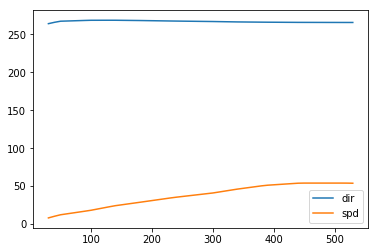

In [28]:
df[0].T.plot()

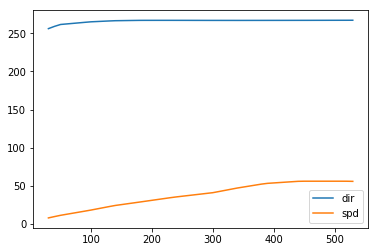

In [29]:
df[1].T.plot()

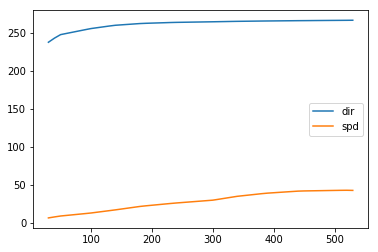

In [30]:
df[2].T.plot()

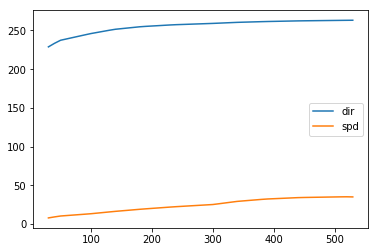

In [31]:
df[3].T.plot()

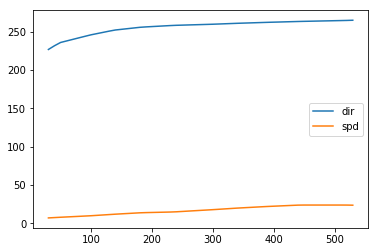

In [32]:
df[4].T.plot()

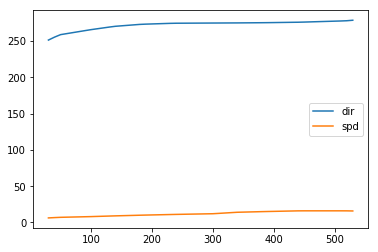

In [33]:
df[5].T.plot()

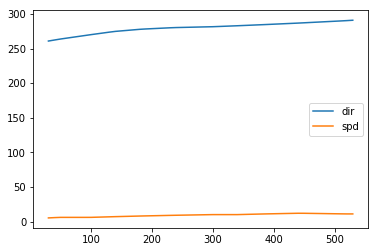

In [34]:
df[6].T.plot()

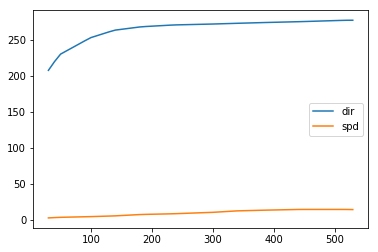

In [35]:
df[7].T.plot()

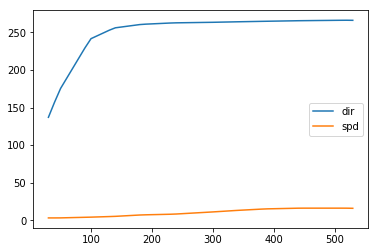

In [36]:
df[8].T.plot()

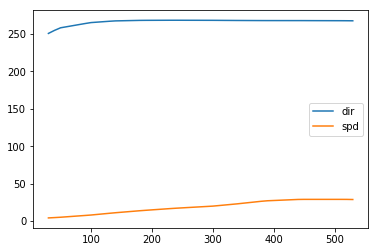

In [37]:
df[9].T.plot()

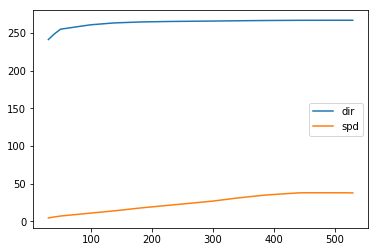

In [38]:
df[10].T.plot()

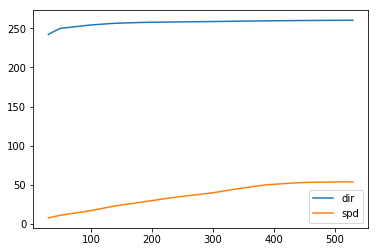

In [39]:
df[11].T.plot()

In [40]:
df[8].T

,dir,spd
30,137.00,3.00
40,156.95,3.00
50,175.47,3.04
60,188.96,3.24
70,202.46,3.44
80,215.95,3.63
90,229.44,3.83
100,241.75,4.03
110,245.50,4.29
120,249.25,4.54


In [ ]:
# %load SeslWndsComp.py
import numpy as np
import pandas as pd
import xarray as xr
import math
from scipy import interpolate



ds_u = xr.open_dataset('uwnd.mon.mean.nc')

# =========  uwnd.mon.mean.nc ======
#
# This data has the following XARRAY dimensions
# -------
# - lat     (Latitude)  --> 73          [Type= float]   90.0,  87.5,  85.0,  82.5  ..... -87.5,  -90.0
# - level   (Level)     --> 17          [Type= float]   1000.0,  925.0,  850.0     ..... 30.0,  20.0,  10.0
# - lon     (Longitude) --> 144         [Type= float]   0.0,  2.5,  5.0            ..... 355.0  357.5
# - time    (Time)      --> 844         [Type=datetime] 1948-01-01,  1948-02-01    ..... 2018-04-01

ds_v = xr.open_dataset('vwnd.mon.mean.nc')
ds_temp = xr.open_dataset('air.mon.mean.nc')

# PRESSURE ALTITUDE
# NOAA formula from converting millibars (mb) to pressure altitude in feet (ft)
#
#     FT = 145366.45 * ( 1 - ( ( Station pressure in mb / 1013.25 )^0.190284  ) ) 
#

# DATA SET/ARRAY FORMAT
#
# LEVEL  [ 0 to 16 ]  - 1000.0 millibar

#iterate through a time period (YEARLY!!!!)
#  -------------------------------------------------------------------------------------
# [768] -> 2012-01-01       [769] -> 2012-02-01     [770] -> 2012-03 ...    [779] -> 2012-12
# [780] -> 2013-01-01       [781] -> 2013-02-01     [782] -> 2013-03 ...    [827] -> 2013-12
# ...                       ...                     ...              ...    ...
# [828] -> 2017-01-01       [829] -> 2017-02-01     [830] -> 2017-03        [839] -> 2017-12
# [840] -> 2018-01          [841] -> 2018-02

# so roughly 5 years
# Start from 2017 backwards to include full-year monthly data (2018 only partial)

start = 828
NUM_YRS = 10

################# RESULT ###############
RESULT_month_wdir_10000ft = np.array([])
RESULT_month_wspd_10000ft = np.array([])

MONTH_IX = {}
MONTH_IX[0] = []
MONTH_IX[1] = []
MONTH_IX[2] = []
MONTH_IX[3] = []
MONTH_IX[4] = []
MONTH_IX[5] = []
MONTH_IX[6] = []
MONTH_IX[7] = []
MONTH_IX[8] = []
MONTH_IX[9] = []
MONTH_IX[10] = []
MONTH_IX[11] = []
for for_year in range(0,NUM_YRS):
    MONTH_IX[0] = MONTH_IX[0] + [ (start+0) - (12*for_year) ]
    MONTH_IX[1] = MONTH_IX[1] + [ (start+1) - (12*for_year) ]
    MONTH_IX[2] = MONTH_IX[2] + [ (start+2) - (12*for_year) ]
    MONTH_IX[3] = MONTH_IX[3] + [ (start+3) - (12*for_year) ]
    MONTH_IX[4] = MONTH_IX[4] + [ (start+4) - (12*for_year) ]
    MONTH_IX[5] = MONTH_IX[5] + [ (start+5) - (12*for_year) ]
    MONTH_IX[6] = MONTH_IX[6] + [ (start+6) - (12*for_year) ]
    MONTH_IX[7] = MONTH_IX[7] + [ (start+7) - (12*for_year) ]
    MONTH_IX[8] = MONTH_IX[8] + [ (start+8) - (12*for_year) ]
    MONTH_IX[9] = MONTH_IX[9] + [ (start+9) - (12*for_year) ]
    MONTH_IX[10] = MONTH_IX[10] + [ (start+10) - (12*for_year) ]
    MONTH_IX[11] = MONTH_IX[11] + [ (start+11) - (12*for_year) ]

    
# Now we have the indeces of all the months for a range of years, separated per month
# ...we need to now start at one geographical point or line and go through the datas for each month
# ...for that particular point

# Start with a fixed latitude
#
#   CHANGE FROM 0-360 DEG TO ....    
#
#     >>> 360|0 >>>
#        --------
#       / /  |  \ \
#     / /    |    \ \
#   / /   ---|---   \ \
#   | |             | |
#   | |----EARTH--- | |
#   | |      |      | |
#   \ \      |      / /
#     \ \ -- | --  / /
#       \ \  | / /
#         --------
# -180       0      180
#
#   ...... -180 > 180 FORMAT

# PICK A SPECIFIC PLACE AND TIME
#
LAT90_ix = 22 # This translates to the 35 deg lat in the dataset

LON360_ix = 110 #At this lon[110] index is the normalized latitude -85.000 deg  (originally '275'degrees)
LON360 = float(ds_u.lon[LON360_ix])
NORM_LONG = ( (LON360 + 180) % 360 ) - 180

LEVEL_MB_ix = 3 # This translates to 700 millibars which is roughly 10,000ft

RESULT = np.array([])

sin_func = np.vectorize(lambda angle: math.sin( math.radians( angle ) ) ) # function that will be applied to all the values
cos_func = np.vectorize(lambda angle: math.cos( math.radians( angle ) ) ) # ...idem...


RESULT_DATA = pd.DataFrame(columns=["lat","long","jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"])

#ITERATE OVER EACH MONTH IN ONE OF THE YEARS

######################
##### PER MONTH ######
#####################
tmp_data = {} #TODO   move this line inside for MONTH loop
for MONTH, data_id in MONTH_IX.items():
    #START with January
    tmp_data[MONTH] = {}
    #zero out all arrays temporarily used for this level
    RESULT_month_wdir = np.array([])
    RESULT_month_wspd = np.array([])
    #...start with January and get the average seasonal winds over the last couple years
    # ... now we start iterating over the different levels as well
    #####################
    ##### LEVELS ########
    #####################
    for LEVEL in range(1,13): # Go from about 2499ft to 51806ft
        level_ft = 145366.45 * ( 1 - ( ( ds_u.level[LEVEL] / 1013.25 )**0.190284  ) ) 
        #level_ft = 145366.45 * ( 1 - ( ( level_mb / 1013.25 )**0.190284  ) ) 
        norm_level_ft = int(round(float(level_ft),0))  # Normalize levels to 1000 ft increments 1000,2000,...,18000,...43000
        flight_level_ft = norm_level_ft / 100  # Convert altitude to Flight Level standard
        # RESULT[lat][long][level][month]
        tmp_data[MONTH][norm_level_ft] = {}
        for for_year in range(0,NUM_YRS):
            # u-wind vector (monthly mean) for this particular lat,long,alt
            u_vect = ds_u.uwnd[int(MONTH_IX[MONTH][for_year]), LEVEL, LAT90_ix, LON360_ix]
            v_vect = ds_v.vwnd[int(MONTH_IX[MONTH][for_year]), LEVEL, LAT90_ix, LON360_ix]
            # calculate wind direction for this particular month and place and altitude based on u/v vector
            # REFERENCES: 
            # math.atan2(y/x)  ---   NOTE: Y / X
            # https://www.eol.ucar.edu/content/wind-direction-quick-reference
            # http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv
            # http://tornado.sfsu.edu/geosciences/classes/m430/Wind/WindDirection.html
            #
            # ------> WIND ANGLES
            wdir_from = round(math.degrees(\
                    math.atan2(\
                    (0 - u_vect), (0 - v_vect))),\
                    2)
            wdir_from = round( (wdir_from + 360 ) %360 , 2)
            # --------> WIND SPEED
            wdir_to = round( (wdir_from + 180) % 360 , 2) #get the angle
            wspd = round( (math.sqrt( (u_vect**2) + (v_vect**2) )) * 1.943844, 2)
            
            RESULT_month_wdir = np.append( RESULT_month_wdir, wdir_from)
            RESULT_month_wspd = np.append( RESULT_month_wspd, wspd)
            #print(str(norm_level_ft)+"ft "+str(for_year)+" | "+str(MONTH)+"= wdir_from: "+str(wdir_from) + \
                    #" -> wdir_to: "+str(wdir_to)+" @ "+ str(wspd) + "   >  u,v = [ "+str( round(float(u_vect),2) )+\
                    #" , " + str(round(float(v_vect),2))+" ]")
        # END OF -> for for_year ...

        #-------------> WIND ANGLES
        # --- MEAN OF ANGLES
        RESULT_month_wdir_sin = sin_func(RESULT_month_wdir) # get the sines of each angle (in radians) and store it in numpy array for easy manipulation
        RESULT_month_wdir_cos = cos_func(RESULT_month_wdir) # get the cosines of each angle
        # now get the arctangent of the mean of the sines and cosines from the values calculated in the above 2 lines
        wdir_mean = round( \
                math.degrees( math.atan2( \
                RESULT_month_wdir_sin.mean(), \
                RESULT_month_wdir_cos.mean() ) ), 2) 
        wdir_mean = round( (wdir_mean + 360 ) % 360, 2)
        wdir_max = RESULT_month_wdir.max() # calculate the max value
        wdir_min = RESULT_month_wdir.min()
        wdir_std = RESULT_month_wdir.std() 
        #------------> WIND SPEED
        wspd_avg = int(round(RESULT_month_wspd.mean(),0)) # calculate the non-circular mean/average of the values in the array
        wspd_max = RESULT_month_wspd.max()
        wspd_min = RESULT_month_wspd.min()
        wspd_std = RESULT_month_wspd.std()
        #
        #STORE
        #...
        tmp_data[MONTH][norm_level_ft] = {'dir':wdir_mean, 'spd':wspd_avg}
        # ====== DEBUG ======
        #print("[[[[ "+str(norm_level_ft)+"ft  @ "+str(MONTH)+" ]]]]")
        #print("--------WIND\n" +\
        #        "MEAN="+str(wdir_mean) + "\n"+ \
        #        "MAX="+str(wdir_max) + "\n"+ \
        #        "MIN="+str(wdir_min) + "\n"+\
        #        "RANGE="+str(wdir_max - wdir_min) + "\n"+\
        #        "STD="+str(wdir_std) + "\n"\
        #        )
        #print("--------SPEED\n" +\
        #        "AVG="+str(wspd_avg) + "\n"+ \
        #        "MAX="+str(wspd_max) + "\n"+ \
        #        "MIN="+str(wspd_min) + "\n"+\
        #        "RANGE="+str(wspd_max - wspd_min) + "\n"+\
        #        "STD="+str(wspd_std) + "\n"\
        #        )
    # END OF ->  FOR LEVEL...
    # ...
    # ...at this point we have the average of January for altitudes from 2499ft to 51806ft at the collected millibar intervals
    # ...now we can use the scipy interpolator function and start building the curated data for the monthly January seasonal winds
    # 
    # FIRST 2 DATA points
    FL = {}
    # 2499 -> 4779  20,30,40
    xdata_alt = [ 2499 , 4779 ]
    ydata_dir = [ tmp_data[MONTH][2499]['dir'] , tmp_data[MONTH][4779]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][2499]['spd'] , tmp_data[MONTH][4779]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(30,40+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }

    # 4779 -> 9878   50,60,70,80,90
    xdata_alt = [ 4779 , 9878 ]
    ydata_dir = [ tmp_data[MONTH][4779]['dir'] , tmp_data[MONTH][9878]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][4779]['spd'] , tmp_data[MONTH][9878]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(50,90+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }

    # 9878 -> 13795   100,110,120,130
    xdata_alt = [ 9878 , 13795 ]
    ydata_dir = [ tmp_data[MONTH][9878]['dir'] , tmp_data[MONTH][13795]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][9878]['spd'] , tmp_data[MONTH][13795]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(100,130+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }
    # 13795 -> 18281   140,150,160,170,180
    xdata_alt = [ 13795 , 18281 ]
    ydata_dir = [ tmp_data[MONTH][13795]['dir'] , tmp_data[MONTH][18281]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][13795]['spd'] , tmp_data[MONTH][18281]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(140,180+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }
    # 18281 -> 23564   190,200,210,220,230
    xdata_alt = [ 18281 , 23564 ]
    ydata_dir = [ tmp_data[MONTH][18281]['dir'] , tmp_data[MONTH][23564]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][18281]['spd'] , tmp_data[MONTH][23564]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(190,230+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }
    # 23564 -> 30053   240,250,260,270,280,290,300
    xdata_alt = [ 23564 , 30053 ]
    ydata_dir = [ tmp_data[MONTH][23564]['dir'] , tmp_data[MONTH][30053]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][23564]['spd'] , tmp_data[MONTH][30053]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(240,300+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }
    # 30053 -> 33985   310,320,330
    xdata_alt = [ 30053 , 33985 ]
    ydata_dir = [ tmp_data[MONTH][30053]['dir'] , tmp_data[MONTH][33985]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][30053]['spd'] , tmp_data[MONTH][33985]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(310,330+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }
    # 33985 -> 38615   340,350,360,370,380
    xdata_alt = [ 33985 , 38615 ]
    ydata_dir = [ tmp_data[MONTH][33985]['dir'] , tmp_data[MONTH][38615]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][33985]['spd'] , tmp_data[MONTH][38615]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(340,380+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }
    # 38615 -> 44302   390,400,410,420,430,440
    xdata_alt = [ 38615 , 44302 ]
    ydata_dir = [ tmp_data[MONTH][38615]['dir'] , tmp_data[MONTH][44302]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][38615]['spd'] , tmp_data[MONTH][44302]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(390,440+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }
    # 44302 -> 51806   450,460,470,480,490,500,510
    xdata_alt = [ 44302 , 51806 ]
    ydata_dir = [ tmp_data[MONTH][44302]['dir'] , tmp_data[MONTH][51806]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][44302]['spd'] , tmp_data[MONTH][51806]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(450,510+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }
    # 51806 -> 57945   520,530
    xdata_alt = [ 51806 , 57945 ]
    ydata_dir = [ tmp_data[MONTH][51806]['dir'] , tmp_data[MONTH][57945]['dir'] ]
    dir_func = interpolate.interp1d(xdata_alt,ydata_dir)
    ydata_spd = [ tmp_data[MONTH][51806]['spd'] , tmp_data[MONTH][57945]['spd'] ]
    spd_func = interpolate.interp1d(xdata_alt,ydata_spd,)
    for lvl in range(520,530+10,10):
        FL[lvl] = { 'dir': round(float(dir_func(lvl*100)),2) , 'spd': round(float(spd_func(lvl*100)),2) }

    df = {}
    df[MONTH] = pd.DataFrame(data=FL)
    #df.plot()
    #print('MONTH '+str(MONTH+1))
    #print(FL)
    #print("\n")

    
# END OF -> FOR MONTH ...
